# 准备工作

In [2]:
import pandas as pd
import talib as tb
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

from datetime import datetime,timedelta
from dateutil.relativedelta import relativedelta

In [3]:
from keras.models import Sequential
from tensorflow.keras import layers
from keras import backend as K
from tensorflow.keras.optimizers import Adam
from keras.layers import Conv1D, MaxPooling1D, Dropout, LSTM, Bidirectional, Dense, Activation
from keras.layers import SimpleRNN,GRU,LSTM,Dense,Dropout
from sklearn.metrics import mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import ParameterGrid

# 市值+波动率 Nasdaq 100 选股

正在获取股票数据...


  0%|          | 0/15 [00:00<?, ?it/s]

已处理 5 个股票，暂停 60 秒...


  7%|▋         | 1/15 [01:02<14:41, 62.98s/it]

已处理 10 个股票，暂停 60 秒...


 13%|█▎        | 2/15 [02:05<13:38, 62.97s/it]

已处理 15 个股票，暂停 60 秒...


 20%|██        | 3/15 [03:08<12:33, 62.78s/it]

已处理 20 个股票，暂停 60 秒...


 27%|██▋       | 4/15 [04:11<11:30, 62.76s/it]

已处理 25 个股票，暂停 60 秒...


 33%|███▎      | 5/15 [05:13<10:26, 62.62s/it]

已处理 30 个股票，暂停 60 秒...


 40%|████      | 6/15 [06:16<09:23, 62.56s/it]

已处理 35 个股票，暂停 60 秒...


 47%|████▋     | 7/15 [07:18<08:20, 62.53s/it]

已处理 40 个股票，暂停 60 秒...


 53%|█████▎    | 8/15 [08:20<07:17, 62.49s/it]

已处理 45 个股票，暂停 60 秒...


 60%|██████    | 9/15 [09:23<06:14, 62.43s/it]

已处理 50 个股票，暂停 60 秒...


 67%|██████▋   | 10/15 [10:25<05:12, 62.47s/it]

已处理 55 个股票，暂停 60 秒...


 73%|███████▎  | 11/15 [11:28<04:10, 62.58s/it]

已处理 60 个股票，暂停 60 秒...


 80%|████████  | 12/15 [12:31<03:07, 62.59s/it]

已处理 65 个股票，暂停 60 秒...


 87%|████████▋ | 13/15 [13:33<02:05, 62.53s/it]

已处理 70 个股票，暂停 60 秒...


 93%|█████████▎| 14/15 [14:36<01:02, 62.67s/it]

已处理 75 个股票，暂停 60 秒...


100%|██████████| 15/15 [15:37<00:00, 62.51s/it]
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHe

   Symbol   AvgTurnover  Volatility
0    AMZN  7.184563e+09    0.279061
1    NVDA  2.956565e+10    0.433664
2   GOOGL  4.162046e+09    0.284506
3    META  6.963475e+09    0.397171
4    GOOG  3.160010e+09    0.284561
5    TSLA  2.428250e+10    0.460159
6    AVGO  3.474924e+09    0.363383
7    ADBE  1.847965e+09    0.358497
8    INTC  1.795443e+09    0.393661
9    QCOM  1.205400e+09    0.274261
10    AMD  1.013989e+10    0.482715
11   ISRG  5.917374e+08    0.296635
12   BKNG  9.097323e+08    0.267791
13   AMAT  1.006437e+09    0.347177
14   LRCX  8.040512e+08    0.322148
15    PDD  1.047627e+09    0.454231
16     MU  1.392407e+09    0.384132
17   VRTX  5.428820e+08    0.280492
18   KLAC  5.563498e+08    0.314466
19   MELI  5.969944e+08    0.325405
20   ASML  8.501283e+08    0.324955
21   PANW  1.453578e+09    0.543203
22   ABNB  7.216173e+08    0.360512
23   SNPS  5.921179e+08    0.313079
24   CRWD  9.385013e+08    0.417164
25   FTNT  4.033957e+08    0.335653
26   WDAY  4.797259e+08    0

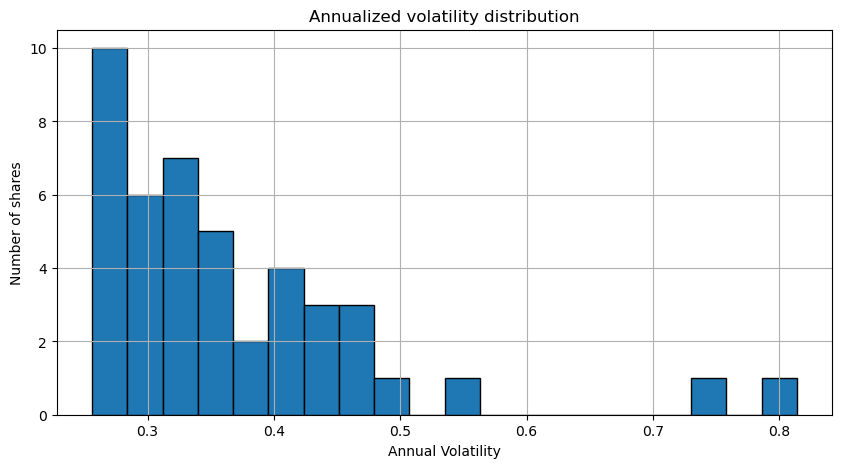

In [68]:
import requests
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import time
from polygon import RESTClient

# === 配置 ===
API_KEY = "XhpppT1ANrQpCxFypnVDEC7mn0a4d1v1"  # 小韵：这里替换成你自己的 API Key
client = RESTClient(API_KEY)

# 设置 matplotlib 显示中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 黑体
plt.rcParams['axes.unicode_minus'] = False  # 正确显示负号

# 1. 获取纳斯达克 100 成分股
def get_nasdaq_100():
    symbols = [
        "AAPL", "MSFT", "AMZN", "NVDA", "GOOGL", "META", "GOOG", "TSLA", "AVGO",
        "PEP", "COST", "ADBE", "CSCO", "TMUS", "AMGN", "TXN", "INTC", "HON",
        "QCOM", "SBUX", "AMD", "ISRG", "BKNG", "AMAT", "ADI", "LRCX", "PDD",
        "MDLZ", "MU", "VRTX", "REGN", "KLAC", "CSX", "MELI", "ADP", "ASML",
        "PANW", "MAR", "ABNB", "CTAS", "SNPS", "CRWD", "MNST", "FTNT", "WDAY",
        "NXPI", "CDNS", "PAYX", "ORLY", "PCAR", "IDXX", "ROST", "XEL", "EBAY",
        "ODFL", "VRSK", "GFS", "ANSS", "TEAM", "MRVL", "FAST", "ZS", "SGEN",
        "BKR", "DXCM", "TTWO", "CHTR", "BIIB", "LCID", "KHC", "DLTR", "CSGP"
    ]
    df = pd.DataFrame({'Symbol': symbols})
    return df

# 2. 获取历史行情并计算指标
def get_stock_metrics(symbol):
    try:
        bars = client.list_aggs(
            ticker=symbol,
            multiplier=1,
            timespan="day",
            from_="2023-10-01",
            to="2024-03-31",
            limit=500
        )

        data = pd.DataFrame([{
            't': bar.timestamp,
            'o': bar.open,
            'h': bar.high,
            'l': bar.low,
            'c': bar.close,
            'v': bar.volume
        } for bar in bars])

        if data.empty:
            print(f"No data for {symbol}")
            return None

        data['Return'] = data['c'].pct_change()

        # 平均成交额
        avg_turnover = (data['c'] * data['v']).mean()

        # 年化波动率
        volatility = data['Return'].std() * np.sqrt(252)

        return avg_turnover, volatility

    except Exception as e:
        print(f"Error fetching data for {symbol}: {e}")
        return None

# 3. 可视化波动率分布
def plot_metrics(stocks_df):
    if stocks_df.empty:
        print("没有符合条件的股票，跳过可视化。")
        return

    plt.figure(figsize=(10, 5))
    plt.hist(stocks_df['Volatility'], bins=20, edgecolor='k')
    plt.title('Annualized volatility distribution')
    plt.xlabel('Annual Volatility')
    plt.ylabel('Number of shares')
    plt.grid(True)
    plt.show()

# 4. 主程序：获取所有股票并筛选
def filter_stocks():
    nasdaq_df = get_nasdaq_100()
    results = []
    failed_symbols = []

    symbols = nasdaq_df['Symbol'].tolist()
    batch_size = 5

    print("正在获取股票数据...")

    for batch_start in tqdm(range(0, len(symbols), batch_size)):
        batch_symbols = symbols[batch_start:batch_start + batch_size]

        for symbol in batch_symbols:
            metrics = get_stock_metrics(symbol)
            time.sleep(0.2)  # 单请求间隔，保险起见
            if metrics:
                avg_turnover, volatility = metrics
                # ✅ 更严格的筛选条件：日均成交额 > 1 亿美元，年化波动率 > 25%
                if avg_turnover > 100_000_000 and volatility > 0.25:
                    results.append({
                        'Symbol': symbol,
                        'AvgTurnover': avg_turnover,
                        'Volatility': volatility
                    })
            else:
                failed_symbols.append(symbol)

        # 每处理一组 batch，暂停 60 秒
        print(f"已处理 {batch_start + batch_size} 个股票，暂停 60 秒...")
        time.sleep(60)

    result_df = pd.DataFrame(results)

    # 保存失败股票记录
    if failed_symbols:
        pd.DataFrame({'FailedSymbols': failed_symbols}).to_csv('failed_symbols.csv', index=False)
        print("失败股票记录已保存为 'failed_symbols.csv'。")

    return result_df

# 5. 执行并输出结果
if __name__ == "__main__":
    filtered_stocks = filter_stocks()
    print(filtered_stocks)

    # 保存到 CSV
    filtered_stocks.to_csv('filtered_nasdaq100_stocks.csv', index=False)
    print("筛选结果已保存为 'filtered_nasdaq100_stocks.csv'")

    # 可视化波动率分布
    plot_metrics(filtered_stocks)


# 导入数据

### 1、获取股价数据

In [69]:
import pandas as pd
from polygon import RESTClient
from tqdm import tqdm
import time

# 配置 API Key
API_KEY = "XhpppT1ANrQpCxFypnVDEC7mn0a4d1v1"
client = RESTClient(API_KEY)

# 读取小韵的筛选股票池
file_path = '//Users//seanice//Desktop//Group 11 Final Project//filtered_nasdaq100_stocks.csv'
stock_pool = pd.read_csv(file_path)


# 定义时间范围（最近两年）
start_date = "2023-04-01"
end_date = "2025-04-14"

# 初始化总数据 DataFrame
all_data = pd.DataFrame()

# 遍历股票池批量获取数据
for idx, symbol in enumerate(tqdm(stock_pool['Symbol'], desc="获取股票数据中")):
    try:
        bars = client.list_aggs(
            ticker=symbol,
            multiplier=1,
            timespan="day",
            from_=start_date,
            to=end_date,
            limit=5000
        )

        df = pd.DataFrame([{
            'ts_code': symbol,
            # ✅ 正确时间转换：毫秒时间戳，unit='ms'，不要除！
            'trade_date': pd.to_datetime(bar.timestamp, unit='ms').strftime('%Y%m%d'),
            'open': bar.open,
            'high': bar.high,
            'low': bar.low,
            'close': bar.close,
            'vol': bar.volume,
            'amount': bar.close * bar.volume
        } for bar in bars])

        if df.empty:
            continue

        df = df.sort_values(by='trade_date').reset_index(drop=True)
        df['pre_close'] = df['close'].shift(1)
        df['change'] = df['close'] - df['pre_close']
        df['pct_chg'] = (df['change'] / df['pre_close']) * 100
        df = df.dropna().reset_index(drop=True)

        all_data = pd.concat([all_data, df], axis=0, ignore_index=True)

        if (idx + 1) % 5 == 0:
            print(f"已完成 {idx + 1} 只股票，暂停 60 秒...")
            time.sleep(60)
        else:
            time.sleep(0.2)

    except Exception as e:
        print(f"Error fetching data for {symbol}: {e}")

# 保存结果
all_data.to_csv('nasdaq100_full_data.csv', index=False)
print("✅ 数据已保存为 'nasdaq100_full_data.csv'")

all_data.head()


获取股票数据中:   9%|▉         | 4/44 [00:02<00:26,  1.51it/s]

已完成 5 只股票，暂停 60 秒...


获取股票数据中:  20%|██        | 9/44 [01:05<03:00,  5.16s/it]

已完成 10 只股票，暂停 60 秒...


获取股票数据中:  32%|███▏      | 14/44 [02:09<02:51,  5.73s/it]

已完成 15 只股票，暂停 60 秒...


获取股票数据中:  43%|████▎     | 19/44 [03:12<02:26,  5.86s/it]

已完成 20 只股票，暂停 60 秒...


获取股票数据中:  55%|█████▍    | 24/44 [04:15<01:56,  5.84s/it]

已完成 25 只股票，暂停 60 秒...


获取股票数据中:  66%|██████▌   | 29/44 [05:19<01:28,  5.91s/it]

已完成 30 只股票，暂停 60 秒...


获取股票数据中:  77%|███████▋  | 34/44 [06:22<00:58,  5.89s/it]

已完成 35 只股票，暂停 60 秒...


获取股票数据中:  91%|█████████ | 40/44 [07:56<00:30,  7.60s/it]

Error fetching data for CHTR: HTTPSConnectionPool(host='api.polygon.io', port=443): Max retries exceeded with url: /v2/aggs/ticker/CHTR/range/1/day/2023-04-01/2025-04-14?limit=5000 (Caused by ResponseError('too many 429 error responses'))


获取股票数据中:  93%|█████████▎| 41/44 [07:58<00:17,  5.74s/it]

Error fetching data for BIIB: HTTPSConnectionPool(host='api.polygon.io', port=443): Max retries exceeded with url: /v2/aggs/ticker/BIIB/range/1/day/2023-04-01/2025-04-14?limit=5000 (Caused by ResponseError('too many 429 error responses'))


获取股票数据中:  95%|█████████▌| 42/44 [07:59<00:08,  4.44s/it]

Error fetching data for LCID: HTTPSConnectionPool(host='api.polygon.io', port=443): Max retries exceeded with url: /v2/aggs/ticker/LCID/range/1/day/2023-04-01/2025-04-14?limit=5000 (Caused by ResponseError('too many 429 error responses'))


获取股票数据中:  98%|█████████▊| 43/44 [08:01<00:03,  3.54s/it]

Error fetching data for DLTR: HTTPSConnectionPool(host='api.polygon.io', port=443): Max retries exceeded with url: /v2/aggs/ticker/DLTR/range/1/day/2023-04-01/2025-04-14?limit=5000 (Caused by ResponseError('too many 429 error responses'))


获取股票数据中: 100%|██████████| 44/44 [08:02<00:00, 10.97s/it]

Error fetching data for CSGP: HTTPSConnectionPool(host='api.polygon.io', port=443): Max retries exceeded with url: /v2/aggs/ticker/CSGP/range/1/day/2023-04-01/2025-04-14?limit=5000 (Caused by ResponseError('too many 429 error responses'))
✅ 数据已保存为 'nasdaq100_full_data.csv'


,ts_code,trade_date,open,high,low,close,vol,amount,pre_close,change,pct_chg
0,AMZN,20230418,103.950,104.20,101.52,102.30,39790518.0,4.070570e+09,102.74,-0.44,-0.428266
1,AMZN,20230419,101.580,105.12,101.39,104.30,58398890.0,6.091004e+09,102.30,2.00,1.955034
2,AMZN,20230420,103.530,105.25,103.21,103.81,57696866.0,5.989512e+09,104.30,-0.49,-0.469799
3,AMZN,20230421,106.100,108.15,105.08,106.96,86734185.0,9.277088e+09,103.81,3.15,3.034390
4,AMZN,20230424,107.655,109.23,105.07,106.21,69572310.0,7.389275e+09,106.96,-0.75,-0.701197


### 2、数据清洗

In [70]:
all_data['trade_date'] = all_data['trade_date'].astype(str)
all_data = all_data.sort_values('trade_date', ascending=True)
all_data.index = pd.to_datetime(all_data['trade_date'])

# 删除不需要的列
all_data.drop(['trade_date', 'pre_close', 'amount'], axis=1, inplace=True)

# 查看结果
print(all_data.head())

# 保存为新的 CSV 文件，供后续建模使用
all_data.to_csv('nasdaq100_sorted.csv')
print("✅ 数据已排序并保存为 'nasdaq100_sorted.csv'")

           ts_code    open    high       low   close         vol  change  \
trade_date                                                                 
2023-04-18    AMZN  103.95  104.20  101.5200  102.30  39790518.0   -0.44   
2023-04-18    CRWD  139.05  139.89  136.1247  136.38   1926935.0   -0.99   
2023-04-18    INTC   32.43   32.46   31.7800   31.83  26041380.0   -0.31   
2023-04-18    KLAC  375.21  376.77  367.6900  371.21    881098.0   -0.90   
2023-04-18    TEAM  169.00  170.20  161.4500  162.32   1321558.0   -4.10   

             pct_chg  
trade_date            
2023-04-18 -0.428266  
2023-04-18 -0.720681  
2023-04-18 -0.964530  
2023-04-18 -0.241864  
2023-04-18 -2.463646  
✅ 数据已排序并保存为 'nasdaq100_sorted.csv'


In [71]:
# 对数据集进行测试
AMZN = all_data[all_data["ts_code"]=="AMZN"]
AMZN

,ts_code,open,high,low,close,vol,change,pct_chg
trade_date,,,,,,,,
2023-04-18,AMZN,103.950,104.2000,101.5200,102.30,39790518.0,-0.44,-0.428266
2023-04-19,AMZN,101.580,105.1200,101.3900,104.30,58398890.0,2.00,1.955034
2023-04-20,AMZN,103.530,105.2500,103.2100,103.81,57696866.0,-0.49,-0.469799
2023-04-21,AMZN,106.100,108.1500,105.0800,106.96,86734185.0,3.15,3.034390
2023-04-24,AMZN,107.655,109.2300,105.0700,106.21,69572310.0,-0.75,-0.701197
...,...,...,...,...,...,...,...,...
2025-04-08,AMZN,185.230,185.9000,168.5700,170.66,87710360.0,-4.60,-2.624672
2025-04-09,AMZN,172.115,192.6500,169.9300,191.10,116804328.0,20.44,11.977030
2025-04-10,AMZN,185.440,186.8692,175.8518,181.22,68302045.0,-9.88,-5.170068


From here

In [4]:
# 读取刚才保存的总表数据
data = pd.read_csv('nasdaq100_sorted.csv')

# 股票代码列表（去重）
ts_code = list(data['ts_code'].unique())

# 初始化字典
stock_data = {}

# 循环把每只股票的数据存进字典
for stock in ts_code:
    stock_data[stock] = data[data['ts_code'] == stock]

# 检查一下效果，比如查看 AMZN 的数据
print(stock_data['AMZN'].head())


     trade_date ts_code     open    high     low   close         vol  change  \
0    2023-04-18    AMZN  103.950  104.20  101.52  102.30  39790518.0   -0.44   
72   2023-04-19    AMZN  101.580  105.12  101.39  104.30  58398890.0    2.00   
113  2023-04-20    AMZN  103.530  105.25  103.21  103.81  57696866.0   -0.49   
150  2023-04-21    AMZN  106.100  108.15  105.08  106.96  86734185.0    3.15   
186  2023-04-24    AMZN  107.655  109.23  105.07  106.21  69572310.0   -0.75   

      pct_chg  
0   -0.428266  
72   1.955034  
113 -0.469799  
150  3.034390  
186 -0.701197  


# 技术指标计算

In [5]:
import talib as tb
import numpy as np
import pandas as pd

# 假设 stock_data 是我们之前整理好的字典
# stock_data = {'AMZN': df1, 'AAPL': df2, ...}

def compute_indicators(df):
    close = np.array(df['close'])
    volume = np.array(df['vol'])
    high = np.array(df['high'])
    low = np.array(df['low'])
    Open = np.array(df['open'])

    df.loc[:, 'MA5'] = tb.MA(close, timeperiod=5)
    df.loc[:, 'MA10'] = tb.MA(close, timeperiod=10)
    df.loc[:, 'MA20'] = tb.MA(close, timeperiod=20)

    MACD, MACDsignal, MACDhist = tb.MACD(close, fastperiod=6, slowperiod=12, signalperiod=9)
    df.loc[:, 'MACD'] = MACD
    df.loc[:, 'MACDsignal'] = MACDsignal
    df.loc[:, 'MACDhist'] = MACDhist

    df.loc[:, 'EMA12'] = tb.EMA(close, timeperiod=12)
    df.loc[:, 'EMA26'] = tb.EMA(close, timeperiod=26)

    df.loc[:, 'ATR'] = tb.ATR(high, low, close)
    df.loc[:, 'OBV'] = tb.OBV(close, volume)
    df.loc[:, 'HT_DC'] = tb.HT_DCPERIOD(close)
    df.loc[:, 'AVG'] = tb.AVGPRICE(Open, high, low, close)
    df.loc[:, 'MED'] = tb.MEDPRICE(high, low)
    df.loc[:, 'ADX'] = tb.ADX(high, low, close)
    df.loc[:, 'SAR'] = tb.SAR(high, low)
    df.loc[:, 'CMO'] = tb.CMO(close)
    df.loc[:, 'DX'] = tb.DX(high, low, close)
    df.loc[:, 'ROC'] = tb.ROC(close)

    return df

# 批量计算所有股票的指标
for stock in stock_data:
    stock_data[stock] = compute_indicators(stock_data[stock])

print("✅ 已完成所有股票的技术指标计算")
# 检查一下结果，举例：
print(stock_data['AMZN'].head())

✅ 已完成所有股票的技术指标计算
     trade_date ts_code     open    high     low   close         vol  change  \
0    2023-04-18    AMZN  103.950  104.20  101.52  102.30  39790518.0   -0.44   
72   2023-04-19    AMZN  101.580  105.12  101.39  104.30  58398890.0    2.00   
113  2023-04-20    AMZN  103.530  105.25  103.21  103.81  57696866.0   -0.49   
150  2023-04-21    AMZN  106.100  108.15  105.08  106.96  86734185.0    3.15   
186  2023-04-24    AMZN  107.655  109.23  105.07  106.21  69572310.0   -0.75   

      pct_chg      MA5  ...  ATR          OBV  HT_DC        AVG      MED  ADX  \
0   -0.428266      NaN  ...  NaN   39790518.0    NaN  102.99250  102.860  NaN   
72   1.955034      NaN  ...  NaN   98189408.0    NaN  103.09750  103.255  NaN   
113 -0.469799      NaN  ...  NaN   40492542.0    NaN  103.95000  104.230  NaN   
150  3.034390      NaN  ...  NaN  127226727.0    NaN  106.57250  106.615  NaN   
186 -0.701197  104.716  ...  NaN   57654417.0    NaN  107.04125  107.150  NaN   

          SAR  

/var/folders/h4/q6cl8fxs5b965kdvmx_s4znc0000gn/T/ipykernel_64756/1389914722.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'MA5'] = tb.MA(close, timeperiod=5)
/var/folders/h4/q6cl8fxs5b965kdvmx_s4znc0000gn/T/ipykernel_64756/1389914722.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'MA10'] = tb.MA(close, timeperiod=10)
/var/folders/h4/q6cl8fxs5b965kdvmx_s4znc0000gn/T/ipykernel_64756/1389914722.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

In [6]:
import os
# 确保保存路径存在
os.makedirs('Data', exist_ok=True)

# 拼接所有股票数据成一个总表
data_list = [stock_data[stock] for stock in stock_data]
data = pd.concat(data_list)

# 保存到 CSV 文件，index=True 保留日期索引
data.to_csv('Data/Stock_dataset.csv', encoding='utf-8', index=True)

print("✅ 数据已成功拼接并保存为 'Data/Stock_dataset.csv'")


✅ 数据已成功拼接并保存为 'Data/Stock_dataset.csv'


# 数据预处理

In [7]:
import pandas as pd

# 读取你刚保存好的总数据
data = pd.read_csv("Data/Stock_dataset.csv", index_col=0)

# 提取股票代码列表（已存在的股票代码）
stock_code = list(data['ts_code'].unique())

# 初始化字典存储每只股票的数据
stock_data = {}

for stock in stock_code:
    df = data[data['ts_code'] == stock].copy()  # ✅ 先 copy 一份，避免 SettingWithCopy 警告
    df.index = pd.to_datetime(df['trade_date'])  # ✅ 重新把 trade_date 设置为索引！
    stock_data[stock] = df

# 统计每只股票的数据描述
for stock in stock_code:
    stock_data_description = stock_data[stock].describe().T
    stock_data_description['null'] = len(stock_data[stock]) - stock_data_description['count']
    stock_data_description = stock_data_description[['count', 'null', 'max', 'min']]
    print(f"✅ 股票 {stock} 的数据统计：\n")
    print(stock_data_description)
    print("\n" + "-"*50 + "\n")


✅ 股票 AMZN 的数据统计：

            count  null           max           min
open        500.0   0.0  2.390150e+02  1.014700e+02
high        500.0   0.0  2.425200e+02  1.039000e+02
low         500.0   0.0  2.380300e+02  1.011500e+02
close       500.0   0.0  2.420600e+02  1.020500e+02
vol         500.0   0.0  1.530914e+08  1.500110e+07
change      500.0   0.0  2.044000e+01 -1.760000e+01
pct_chg     500.0   0.0  1.197703e+01 -8.979134e+00
MA5         496.0   4.0  2.384320e+02  1.037560e+02
MA10        491.0   9.0  2.372290e+02  1.047635e+02
MA20        481.0  19.0  2.341555e+02  1.060833e+02
MACD        481.0  19.0  5.543622e+00 -6.565140e+00
MACDsignal  481.0  19.0  4.517694e+00 -4.947491e+00
MACDhist    481.0  19.0  2.605623e+00 -2.890441e+00
EMA12       489.0  11.0  2.356781e+02  1.045451e+02
EMA26       475.0  25.0  2.312139e+02  1.082679e+02
ATR         486.0  14.0  1.087625e+01  2.805450e+00
OBV         500.0   0.0  2.311004e+09 -7.372401e+06
HT_DC       468.0  32.0  4.463825e+01  1.56467

In [8]:
# 处理缺失值：用 0 填充 NaN，并更新 stock_data 字典
for stock in stock_code:
    df = stock_data[stock].copy()
    df.fillna(0, inplace=True)
    stock_data[stock] = df.copy()

print("✅ 已完成所有股票的缺失值填充处理")

✅ 已完成所有股票的缺失值填充处理


In [9]:
for stock in stock_code:
    stock_data_description = stock_data[stock].describe().T
    stock_data_description['null'] = len(stock_data[stock]) - stock_data_description['count']
    stock_data_description = stock_data_description[['null', 'max', 'min']]
    print(f"✅ 股票 {stock} 的填充后数据统计：\n")
    print(stock_data_description)
    print("\n" + "-"*50 + "\n")

✅ 股票 AMZN 的填充后数据统计：

            null           max           min
open         0.0  2.390150e+02  1.014700e+02
high         0.0  2.425200e+02  1.039000e+02
low          0.0  2.380300e+02  1.011500e+02
close        0.0  2.420600e+02  1.020500e+02
vol          0.0  1.530914e+08  1.500110e+07
change       0.0  2.044000e+01 -1.760000e+01
pct_chg      0.0  1.197703e+01 -8.979134e+00
MA5          0.0  2.384320e+02  0.000000e+00
MA10         0.0  2.372290e+02  0.000000e+00
MA20         0.0  2.341555e+02  0.000000e+00
MACD         0.0  5.543622e+00 -6.565140e+00
MACDsignal   0.0  4.517694e+00 -4.947491e+00
MACDhist     0.0  2.605623e+00 -2.890441e+00
EMA12        0.0  2.356781e+02  0.000000e+00
EMA26        0.0  2.312139e+02  0.000000e+00
ATR          0.0  1.087625e+01  0.000000e+00
OBV          0.0  2.311004e+09 -7.372401e+06
HT_DC        0.0  4.463825e+01  0.000000e+00
AVG          0.0  2.404050e+02  1.025375e+02
MED          0.0  2.402750e+02  1.025250e+02
ADX          0.0  4.351390e+01  0.

In [10]:
# 初始化输入特征字典
Stock_X = {}
for stock in stock_code:
    Stock_X[stock] = stock_data[stock].drop(['close', 'trade_date', 'ts_code'], axis=1)



print("✅ 已提取所有股票的输入特征，用于后续 PCA 和归一化处理")

# 示例：展示 AMZN 的输入特征数据
print("✅ AMZN 股票输入特征预览：\n")
print(Stock_X['AMZN'].head())

✅ 已提取所有股票的输入特征，用于后续 PCA 和归一化处理
✅ AMZN 股票输入特征预览：

               open    high     low         vol  change   pct_chg      MA5  \
trade_date                                                                   
2023-04-18  103.950  104.20  101.52  39790518.0   -0.44 -0.428266    0.000   
2023-04-19  101.580  105.12  101.39  58398890.0    2.00  1.955034    0.000   
2023-04-20  103.530  105.25  103.21  57696866.0   -0.49 -0.469799    0.000   
2023-04-21  106.100  108.15  105.08  86734185.0    3.15  3.034390    0.000   
2023-04-24  107.655  109.23  105.07  69572310.0   -0.75 -0.701197  104.716   

            MA10  MA20  MACD  ...  ATR          OBV  HT_DC        AVG  \
trade_date                    ...                                       
2023-04-18   0.0   0.0   0.0  ...  0.0   39790518.0    0.0  102.99250   
2023-04-19   0.0   0.0   0.0  ...  0.0   98189408.0    0.0  103.09750   
2023-04-20   0.0   0.0   0.0  ...  0.0   40492542.0    0.0  103.95000   
2023-04-21   0.0   0.0   0.0  ...  0.0 

In [11]:
# 初始化收盘价字典
Stock_Y = {}

# 提取每只股票的收盘价，存入 Stock_Y 字典
for stock in stock_code:
    Stock_Y[stock] = pd.DataFrame({'close': stock_data[stock]['close']})

print("✅ 已提取所有股票的收盘价，用于后续作为标签变量")

# 示例：展示 AMZN 股票的收盘价
print("✅ AMZN 股票收盘价预览：\n")
print(Stock_Y['AMZN'].head())

✅ 已提取所有股票的收盘价，用于后续作为标签变量
✅ AMZN 股票收盘价预览：

             close
trade_date        
2023-04-18  102.30
2023-04-19  104.30
2023-04-20  103.81
2023-04-21  106.96
2023-04-24  106.21


In [12]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# 存储每只股票输入特征的归一化结果
X_scaled = {}

for stock in stock_code:
    mm = MinMaxScaler()
    X_scaled[stock] = pd.DataFrame(
        mm.fit_transform(Stock_X[stock]),
        columns=Stock_X[stock].columns,
        index=Stock_X[stock].index
    )

print("✅ 所有股票输入特征已完成归一化处理")

# 查看某只股票归一化后的数据，例如 AMZN
print("✅ AMZN 股票归一化后的数据预览：\n")
print(X_scaled['AMZN'].head())


✅ 所有股票输入特征已完成归一化处理
✅ AMZN 股票归一化后的数据预览：

                open      high       low       vol    change   pct_chg  \
trade_date                                                               
2023-04-18  0.018030  0.002164  0.002703  0.179516  0.451104  0.408036   
2023-04-19  0.000800  0.008801  0.001753  0.314271  0.515247  0.521764   
2023-04-20  0.014977  0.009739  0.015050  0.309187  0.449790  0.406054   
2023-04-21  0.033662  0.030659  0.028711  0.519465  0.545478  0.573269   
2023-04-24  0.044967  0.038450  0.028638  0.395185  0.442955  0.395012   

                 MA5  MA10  MA20      MACD  ...  ATR       OBV  HT_DC  \
trade_date                                  ...                         
2023-04-18  0.000000   0.0   0.0  0.542181  ...  0.0  0.020343    0.0   
2023-04-19  0.000000   0.0   0.0  0.542181  ...  0.0  0.045533    0.0   
2023-04-20  0.000000   0.0   0.0  0.542181  ...  0.0  0.020646    0.0   
2023-04-21  0.000000   0.0   0.0  0.542181  ...  0.0  0.058057    0.0   
202

# PCA降维

In [13]:
from sklearn.decomposition import PCA
import pandas as pd

X_PCA = {}        # 存储每只股票降维后的数据
PCA_result = {}   # 存储每只股票 PCA 分析结果

for stock in stock_code:
    data = X_scaled[stock].copy()
    # print(data.head())  # 可选：只查看前几行，避免输出太长

    # 确保至少有两个特征才能做 PCA
    if data.shape[1] < 2:
        print(f"⚠️ 股票 {stock} 特征数不足，跳过 PCA")
        X_PCA[stock] = data.copy()
        continue

    # 初始化 PCA
    pca = PCA()
    data_pca = pca.fit_transform(data)

    # 主成分贡献率 & 特征值
    formatted_ratio = ["{:.2%}".format(ratio) for ratio in pca.explained_variance_ratio_]
    eigenvalue = ["{:.4f}".format(variance) for variance in pca.explained_variance_]

    # 累计贡献率
    s = 0
    cumulative_ratio = []
    for variance_ratio in pca.explained_variance_ratio_:
        if s < 0.95:
            s += variance_ratio
            cumulative_ratio.append("{:.2%}".format(s))

    # 分析结果存储
    result = pd.DataFrame({
        '特征值': eigenvalue[:len(cumulative_ratio)],
        '方差百分比': formatted_ratio[:len(cumulative_ratio)],
        '累计方差贡献率': cumulative_ratio
    })

    print(f"\n✅ {stock} 数据集 PCA 分析：\n{result}")
    PCA_result[stock] = result

    # 保留主成分个数
    k = len(result.index)

    # 重新 PCA 降维，保留前 k 个主成分
    pca = PCA(n_components=k)
    data_pca = pca.fit_transform(data)

    # 构建降维后的 DataFrame
    columns_name = [f"主成分{i+1}" for i in range(k)]
    df = pd.DataFrame(data_pca, columns=columns_name, index=data.index)

    # 存储结果
    X_PCA[stock] = df

print("\n✅ 所有股票 PCA 降维完成！")



✅ AMZN 数据集 PCA 分析：
      特征值   方差百分比 累计方差贡献率
0  0.5393  59.34%  59.34%
1  0.1424  15.67%  75.00%
2  0.0849   9.34%  84.34%
3  0.0389   4.28%  88.62%
4  0.0343   3.78%  92.40%
5  0.0172   1.90%  94.30%
6  0.0147   1.62%  95.92%

✅ CRWD 数据集 PCA 分析：
      特征值   方差百分比 累计方差贡献率
0  0.6752  67.43%  67.43%
1  0.1191  11.90%  79.33%
2  0.0801   8.00%  87.33%
3  0.0303   3.03%  90.36%
4  0.0298   2.98%  93.33%
5  0.0218   2.18%  95.51%

✅ INTC 数据集 PCA 分析：
      特征值   方差百分比 累计方差贡献率
0  0.5571  56.69%  56.69%
1  0.1414  14.39%  71.08%
2  0.0913   9.29%  80.37%
3  0.0573   5.83%  86.20%
4  0.0324   3.30%  89.50%
5  0.0268   2.73%  92.23%
6  0.0207   2.10%  94.33%
7  0.0147   1.50%  95.82%

✅ KLAC 数据集 PCA 分析：
      特征值   方差百分比 累计方差贡献率
0  0.5510  58.67%  58.67%
1  0.1536  16.36%  75.03%
2  0.0804   8.57%  83.60%
3  0.0442   4.71%  88.30%
4  0.0277   2.95%  91.25%
5  0.0193   2.06%  93.31%
6  0.0175   1.87%  95.18%

✅ TEAM 数据集 PCA 分析：
      特征值   方差百分比 累计方差贡献率
0  0.4175  55.97%  55.97%
1  0.1307  17.52

# CNN-GRU 模型搭建

### 1、归一化处理

In [14]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# 存储每只股票归一化后的收盘价
y_scaled = {}
# 存储每只股票的 MinMaxScaler 实例，方便后续反归一化
y_mm_scaler = {}

for stock in stock_code:
    mm = MinMaxScaler()
    scaled_close = mm.fit_transform(Stock_Y[stock])

    y_scaled[stock] = pd.DataFrame(
        scaled_close,
        columns=Stock_Y[stock].columns,
        index=Stock_Y[stock].index
    )

    y_mm_scaler[stock] = mm  # 保存 scaler 以便后续逆变换

print("✅ 所有股票收盘价已完成归一化处理")

# 查看 AMZN 股票归一化后的数据
print("✅ AMZN 股票收盘价归一化结果预览：\n")
print(y_scaled['AMZN'].head())

✅ 所有股票收盘价已完成归一化处理
✅ AMZN 股票收盘价归一化结果预览：

               close
trade_date          
2023-04-18  0.001786
2023-04-19  0.016070
2023-04-20  0.012571
2023-04-21  0.035069
2023-04-24  0.029712


### 2、划分数据维度

In [15]:
import numpy as np
import pandas as pd

# 初始化存储字典
X_processed_dict = {}
y_processed_dict = {}

# 设置参数：是否使用 PCA 降维后的数据
use_pca = True
timesteps = 30  # 时间窗口长度

for stock in stock_code:
    # 选择特征数据：PCA or 原始归一化数据
    X_GZMT = X_PCA[stock] if use_pca else X_scaled[stock]
    Y_GZMT = y_scaled[stock]

    # 初始化存储列表
    X_processed = []
    y_processed = []

    # 只有当数据量足够时，才进行处理
    if len(X_GZMT) > timesteps:
        for i in range(len(X_GZMT) - timesteps):
            X_processed.append(X_GZMT.iloc[i:(i + timesteps)].values)
            y_processed.append(Y_GZMT.iloc[i + timesteps].values)  # 注意 .values，保证是 array

        # 转成 NumPy 数组
        X_processed = np.array(X_processed)
        y_processed = np.array(y_processed).reshape(-1, 1)

        # 检查 shape
        print(f"✅ 股票 {stock} 处理完成！X shape: {X_processed.shape}，Y shape: {y_processed.shape}")

        # 存储到字典
        X_processed_dict[stock] = X_processed
        y_processed_dict[stock] = y_processed

    else:
        print(f"⚠️ 股票 {stock} 数据量不足 {timesteps} 天，已跳过！")

print("\n✅ 全部股票的时间序列数据构造完成！")


✅ 股票 AMZN 处理完成！X shape: (470, 30, 7)，Y shape: (470, 1)
✅ 股票 CRWD 处理完成！X shape: (470, 30, 6)，Y shape: (470, 1)
✅ 股票 INTC 处理完成！X shape: (470, 30, 8)，Y shape: (470, 1)
✅ 股票 KLAC 处理完成！X shape: (470, 30, 7)，Y shape: (470, 1)
✅ 股票 TEAM 处理完成！X shape: (470, 30, 9)，Y shape: (470, 1)
✅ 股票 TSLA 处理完成！X shape: (470, 30, 8)，Y shape: (470, 1)
✅ 股票 VRTX 处理完成！X shape: (470, 30, 7)，Y shape: (470, 1)
✅ 股票 ABNB 处理完成！X shape: (470, 30, 9)，Y shape: (470, 1)
✅ 股票 CDNS 处理完成！X shape: (470, 30, 9)，Y shape: (470, 1)
✅ 股票 ISRG 处理完成！X shape: (470, 30, 7)，Y shape: (470, 1)
✅ 股票 BKNG 处理完成！X shape: (470, 30, 7)，Y shape: (470, 1)
✅ 股票 NXPI 处理完成！X shape: (470, 30, 8)，Y shape: (470, 1)
✅ 股票 META 处理完成！X shape: (470, 30, 6)，Y shape: (470, 1)
✅ 股票 ZS 处理完成！X shape: (470, 30, 8)，Y shape: (470, 1)
✅ 股票 FTNT 处理完成！X shape: (470, 30, 7)，Y shape: (470, 1)
✅ 股票 LRCX 处理完成！X shape: (470, 30, 8)，Y shape: (470, 1)
✅ 股票 TTWO 处理完成！X shape: (470, 30, 8)，Y shape: (470, 1)
✅ 股票 MRVL 处理完成！X shape: (470, 30, 6)，Y shape: (470, 1)
✅ 股票 GOOG 处理

### 3、划分训练集、测试集

In [16]:
import numpy as np

def split_train_test_time_series(X, y, train_size=0.8):
    """
    按时间序列顺序划分数据为训练集和测试集。

    参数:
    X -- 特征数据集，形状 (samples, timesteps, features)
    y -- 目标数据集，形状 (samples,) 或 (samples, output_features)
    train_size -- 训练集比例 (默认 0.8)

    返回:
    x_train, x_test, y_train, y_test
    """
    # 样本数量
    total_samples = X.shape[0]
    train_samples = int(total_samples * train_size)

    # 检查是否有足够的样本
    if train_samples == 0 or train_samples == total_samples:
        raise ValueError(f"数据样本数不足以进行训练/测试划分！当前总样本数：{total_samples}")

    # 划分数据集
    x_train = X[:train_samples]
    x_test = X[train_samples:]
    y_train = y[:train_samples]
    y_test = y[train_samples:]

    # 打印数据集信息
    print(f"✅ 数据集划分完成：总样本数 {total_samples}")
    print(f"训练集样本数：{x_train.shape[0]}，测试集样本数：{x_test.shape[0]}")

    return x_train, x_test, y_train, y_test


![image.png](attachment:image.png)

### 4、CNN-GRU 模型搭建

In [17]:
import numpy as np
from keras.models import Sequential
from tensorflow.keras import layers
from keras import backend as K
from tensorflow.keras.optimizers import Adam
from keras.layers import Conv1D, MaxPooling1D, Dropout, LSTM, Bidirectional, Dense, Activation
from sklearn.metrics import mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping

# 自定义 Attention 层
class AttentionLayer(layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # 创建可训练的权重
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1), initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1), initializer="zeros")
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        # 使用softmax函数计算权重
        et = K.squeeze(K.tanh(K.dot(inputs, self.W) + self.b), axis=-1)
        at = K.softmax(et)
        at = K.expand_dims(at, axis=-1)
        output = inputs * at
        return K.sum(output, axis=1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

def Create_CNN_BiLSTM_Attention(filters, kernel_size, strides, pool_size, dropout, BiLSTM_units, input_shape):
    """
    构建基于CNN-BiLSTM-Attention的深度学习模型

    参数:
    - filters1: 卷积层的过滤器数量
    - kernel_size1: 卷积核大小
    - strides1: 卷积步幅
    - BiLSTM_units: BiLSTM 层的神经元数量
    - dropout: Dropout 比例
    - input_shape: 输入数据的形状
    - output_shape: 输出数据的形状（默认为1）

    返回:
    - 编译后的 Keras 模型
    """
    # 模型定义
    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, strides=strides, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Dropout(dropout))
    model.add(Bidirectional(LSTM(BiLSTM_units, return_sequences=True, activation='tanh')))
    model.add(AttentionLayer())
    model.add(Dense(1))  # 假设你的输出是单变量的收盘价格
    #optimizer = Adam(learning_rate=0.005)
    model.compile(optimizer="adam", loss='mean_squared_error')
    model.summary()
    return model

In [18]:
import numpy as np
from keras.models import Sequential
from keras.layers import SimpleRNN,GRU,LSTM,Dense,Dropout
from sklearn.metrics import mean_squared_error

def Create_CNN_GRU(filters, kernel_size, strides, pool_size, dropout1, dropout2, GRU_units, input_shape):
    # 构建GRU模型
    model = Sequential()
    model.add(Conv1D(filters,kernel_size,strides, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Dropout(dropout1))  #在GRU单元内部的输入连接上应用的Dropout比率
    model.add(GRU(GRU_units))
    model.add(Dropout(dropout2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model
def Create_RNN(dropout, RNN_units,input_shape):
    # 构建模型
    model = Sequential()
    model.add(SimpleRNN(RNN_units, input_shape=input_shape, activation='relu'))
    model.add(Dropout(dropout))            
    model.add(Dense(1))
    model.compile(optimizer="adam", loss='mean_squared_error')
    return model
def Create_LSTM(dropout, LSTM_units, input_shape):
    model = Sequential()
    model.add(LSTM(LSTM_units, input_shape=input_shape))
    model.add(Dropout(dropout)) 
    model.add(Dense(1))
    model.compile(optimizer="adam", loss='mean_squared_error')
    return model
def Create_BiLSTM(dropout, BiLSTM_units, input_shape):
    model = Sequential()
    model.add(Bidirectional(LSTM(BiLSTM_units, return_sequences=False, activation='tanh'), input_shape=input_shape))
    model.add(Dropout(dropout)) 
    model.add(Dense(1))
    #optimizer = Adam(learning_rate=0.005)
    model.compile(optimizer="adam", loss='mean_squared_error')
    return model
def Create_CNN_BiLSTM(filters, kernel_size, strides, pool_size, dropout1, dropout2, BiLSTM_units, input_shape):
    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, strides=strides, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Dropout(dropout1))
    model.add(Bidirectional(LSTM(BiLSTM_units, return_sequences=False, activation='tanh')))
    model.add(Dropout(dropout2))
    model.add(Dense(1))
    model.compile(optimizer="adam", loss='mean_squared_error')
    return model
def Create_CNN_LSTM(filters, kernel_size, strides, pool_size, dropout1, dropout2, LSTM_units, input_shape):
    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, strides=strides, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Dropout(dropout1))
    model.add(LSTM(LSTM_units, return_sequences=False, activation='tanh'))
    model.add(Dropout(dropout2))
    model.add(Dense(1))
    model.compile(optimizer="adam", loss='mean_squared_error')
    return model
def Create_GRU(dropout, GRU_units,input_shape):
    # 构建GRU模型
    model = Sequential()
    model.add(GRU(GRU_units,input_shape=input_shape))
    model.add(Dropout(dropout))  #在GRU单元内部的输入连接上应用的Dropout比率
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import os

def Model_Training(Model_name, params):
    MAE_dict = {}
    MSE_dict = {}
    MAPE_dict = {}
    Y_test_dict = {}
    Y_predict_dict = {}

    # 确保保存目录存在
    os.makedirs('model_outputs', exist_ok=True)

    for stock in stock_code:
        print(f"\n🚀 开始训练股票：{stock}")

        # 划分训练集和测试集
        x_train, x_test, y_train, y_test = split_train_test_time_series(X_processed_dict[stock], y_processed_dict[stock])
        Y_test_dict[stock] = y_test

        input_dim = x_train.shape[2]  # 特征维度
        time_steps = 30
        input_shape = (time_steps, input_dim)
        batch_size = 128
        epochs = 100

        y_test_predict_all = []

        # 训练模型 3 次取平均
        for i in range(3):
            if Model_name == "CNN_BiLSTM_Attention":
                model = Create_CNN_BiLSTM_Attention(
                    filters=params['filters'],
                    kernel_size=params['kernel_size'],
                    strides=params['strides'],
                    pool_size=params['pool_size'],
                    BiLSTM_units=params['BiLSTM_units'],
                    dropout=params['dropout'],
                    input_shape=input_shape
                )
            else:
                print(f"❌ 模型 {Model_name} 暂未实现，跳过")
                break

            early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

            history = model.fit(
                x_train, y_train,
                epochs=epochs,
                batch_size=batch_size,
                validation_data=(x_test, y_test),
                callbacks=[early_stopping],
                verbose=0
            )

            # ✅ 保存模型和结构图（示例保存 AMZN）
            if stock == "AMZN":
                model_path = f'model_outputs/{Model_name}_{stock}_run{i+1}_model.h5'
                model_structure_path = f'model_outputs/{Model_name}_{stock}_run{i+1}_model_structure.png'
                
                model.save(model_path)
                print(f"✅ 模型保存完成：{model_path}")
                
                from tensorflow.keras.utils import plot_model
                plot_model(model, to_file=model_structure_path, show_shapes=True)
                print(f"✅ 模型结构图保存完成：{model_structure_path}")

            # 模型预测
            y_test_predict = model.predict(x_test, verbose=0)
            y_test_predict_all.append(y_test_predict)

        # 计算平均预测结果
        y_test_predict_avg = np.mean(y_test_predict_all, axis=0)
        Y_predict_dict[stock] = y_test_predict_avg

        # 计算 MAE
        mae = mean_absolute_error(y_test, y_test_predict_avg)
        MAE_dict[stock] = mae
        print(f"{stock} Mean Absolute Error (MAE): {mae}")

        # 计算 MSE
        mse = mean_squared_error(y_test, y_test_predict_avg)
        MSE_dict[stock] = mse
        print(f"{stock} Mean Squared Error (MSE): {mse}")

        # 计算 MAPE
        epsilon = 1e-10
        mape = np.mean(np.abs((y_test - y_test_predict_avg) / (y_test + epsilon))) * 100
        MAPE_dict[stock] = mape
        print(f"{stock} Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

    print("\n✅ 所有股票模型训练完成！")
    return MAE_dict, MSE_dict, MAPE_dict, Y_test_dict, Y_predict_dict


In [20]:
def prediction_validation(MAE_dict, MSE_dict, MAPE_dict):
    mae = []
    mse = []
    mape = []

    # 遍历所有股票，把对应的评估指标取出来
    for stock in stock_code:
        mae.append(MAE_dict.get(stock, np.nan))
        mse.append(MSE_dict.get(stock, np.nan))
        mape.append(MAPE_dict.get(stock, np.nan))

    # 整理成 DataFrame
    prediction_result = pd.DataFrame({
        "股票代码": stock_code,
        "MAE": mae,
        "MSE": mse,
        "MAPE": mape
    })

    return prediction_result


# 训练最优参数

In [21]:
def initialize_train_data(stock_code, X_processed_dict, y_processed_dict):
    print("✅ 初始化训练数据...")
    stock = stock_code[0]  # 用贵州茅台做调参样本
    x_train, x_test, y_train, y_test = split_train_test_time_series(X_processed_dict[stock], y_processed_dict[stock])
    input_dim = x_train.shape[2]
    time_steps = 30
    input_shape = (time_steps, input_dim)
    print("✅ 初始化完成！")
    return x_train, x_test, y_train, y_test, input_shape

x_train, x_test, y_train, y_test, input_shape = initialize_train_data(stock_code, X_processed_dict, y_processed_dict)


✅ 初始化训练数据...
✅ 数据集划分完成：总样本数 470
训练集样本数：376，测试集样本数：94
✅ 初始化完成！


In [22]:
from sklearn.model_selection import ParameterGrid
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
import gc
from keras import backend as K
import os

def Search_CNN_GRU_Best_Params(x_train, y_train, x_test, y_test, input_shape):
    # 🔥 全组合参数组合：共 1152 组
    param_grid = {
        'filters': [32, 64],
        'kernel_size': [2, 3],
        'strides': [1, 2],
        'pool_size': [1, 2],
        'GRU_units': [64, 128],
        'dropout1': [0.15, 0.3],
        'dropout2': [0.1, 0.15]
    }
    
    best_params = None
    best_test_mape = float('inf')
    grid = list(ParameterGrid(param_grid))

    results = []

    # 创建输出目录
    os.makedirs('model_outputs', exist_ok=True)
    results_file = 'model_outputs/CNN_GRU_param_search_results_full.csv'

    for idx, params in enumerate(grid):
        print(f"[{idx + 1}/{len(grid)}] Training with params: {params}")
        try:
            model = Create_CNN_GRU(
                filters=params['filters'],
                kernel_size=params['kernel_size'],
                strides=params['strides'],
                pool_size=params['pool_size'],
                GRU_units=params['GRU_units'],
                dropout1=params['dropout1'],
                dropout2=params['dropout2'],
                input_shape=input_shape
            )

            early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

            # 训练模型
            model.fit(
                x_train, y_train,
                epochs=50,
                batch_size=128,
                validation_data=(x_test, y_test),
                callbacks=[early_stopping],
                verbose=0
            )

            # 预测结果
            y_test_predict = model.predict(x_test, verbose=0)
            epsilon = 1e-10
            test_mape = np.mean(np.abs((y_test - y_test_predict) / (y_test + epsilon))) * 100
            print(f"Test MAPE: {test_mape:.4f}%")

            # 记录结果
            result_record = {**params, 'MAPE': test_mape}
            results.append(result_record)

            # 每轮都保存
            results_df = pd.DataFrame(results)
            results_df.to_csv(results_file, index=False)
            print(f"中间结果已保存到：{results_file}")

            # 更新最佳参数
            if test_mape < best_test_mape:
                best_test_mape = test_mape
                best_params = params

            # 释放内存
            K.clear_session()
            gc.collect()

        except Exception as e:
            print(f"发生异常：{e}，跳过本轮参数组合")
            continue

    print(f"搜索完成！最佳参数组合：{best_params}，Test MAPE: {best_test_mape:.4f}%")
    print(f"全部参数组合结果保存为：{results_file}")

    return best_params


In [23]:
stock = stock_code[0]
x_train, x_test, y_train, y_test = split_train_test_time_series(X_processed_dict[stock], y_processed_dict[stock])
input_dim = x_train.shape[2]
time_steps = 30
input_shape = (time_steps, input_dim)

best_params = Search_CNN_GRU_Best_Params(x_train, y_train, x_test, y_test, input_shape)


✅ 数据集划分完成：总样本数 470
训练集样本数：376，测试集样本数：94
[1/128] Training with params: {'GRU_units': 64, 'dropout1': 0.15, 'dropout2': 0.1, 'filters': 32, 'kernel_size': 2, 'pool_size': 1, 'strides': 1}


2025-04-15 21:30:03.390901: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Test MAPE: 5.0246%
中间结果已保存到：model_outputs/CNN_GRU_param_search_results_full.csv
[2/128] Training with params: {'GRU_units': 64, 'dropout1': 0.15, 'dropout2': 0.1, 'filters': 32, 'kernel_size': 2, 'pool_size': 1, 'strides': 2}
Test MAPE: 15.9596%
中间结果已保存到：model_outputs/CNN_GRU_param_search_results_full.csv
[3/128] Training with params: {'GRU_units': 64, 'dropout1': 0.15, 'dropout2': 0.1, 'filters': 32, 'kernel_size': 2, 'pool_size': 2, 'strides': 1}
Test MAPE: 6.4214%
中间结果已保存到：model_outputs/CNN_GRU_param_search_results_full.csv
[4/128] Training with params: {'GRU_units': 64, 'dropout1': 0.15, 'dropout2': 0.1, 'filters': 32, 'kernel_size': 2, 'pool_size': 2, 'strides': 2}
Test MAPE: 10.5587%
中间结果已保存到：model_outputs/CNN_GRU_param_search_results_full.csv
[5/128] Training with params: {'GRU_units': 64, 'dropout1': 0.15, 'dropout2': 0.1, 'filters': 32, 'kernel_size': 3, 'pool_size': 1, 'strides': 1}
Test MAPE: 8.9483%
中间结果已保存到：model_outputs/CNN_GRU_param_search_results_full.csv
[6/128] Traini

# 模型预测选股

### 1、模型预测

In [24]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 用最佳参数训练所有股票
all_results = []

for stock in stock_code:
    print(f"\n开始训练股票：{stock}")

    # 数据准备
    x_train, x_test, y_train, y_test = split_train_test_time_series(X_processed_dict[stock], y_processed_dict[stock])
    input_dim = x_train.shape[2]
    time_steps = 30
    input_shape = (time_steps, input_dim)

    try:
        # 建模
        model = Create_CNN_GRU(
            filters=best_params['filters'],
            kernel_size=best_params['kernel_size'],
            strides=best_params['strides'],
            pool_size=best_params['pool_size'],
            GRU_units=best_params['GRU_units'],
            dropout1=best_params['dropout1'],
            dropout2=best_params['dropout2'],
            input_shape=input_shape
        )

        # 训练
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        model.fit(x_train, y_train, epochs=50, batch_size=128, validation_data=(x_test, y_test),
                  callbacks=[early_stopping], verbose=0)

        # 预测
        y_test_predict = model.predict(x_test, verbose=0).reshape(-1)
        y_test_true = y_test.reshape(-1)

        # 计算误差指标
        mae = mean_absolute_error(y_test_true, y_test_predict)
        mse = mean_squared_error(y_test_true, y_test_predict)
        epsilon = 1e-10
        mape = np.mean(np.abs((y_test_true - y_test_predict) / (y_test_true + epsilon))) * 100

        print(f"{stock} 结果：MAE={mae:.4f}  MSE={mse:.4f}  MAPE={mape:.4f}%")

        # 保存单股票结果
        df_result = pd.DataFrame({
            'True': y_test_true,
            'Predicted': y_test_predict
        })
        df_result.to_csv(f'Predict_res/{stock}_predict_res.csv', index=False)

        # 汇总结果
        all_results.append({
            'Stock': stock,
            'MAE': mae,
            'MSE': mse,
            'MAPE': mape
        })

    except Exception as e:
        print(f"{stock} 发生错误，跳过。错误信息：{e}")
        continue

# 保存所有股票汇总结果
df_summary = pd.DataFrame(all_results)
df_summary.to_csv('Predict_res/all_stocks_summary.csv', index=False)
print("\n✅ 所有股票训练完成，汇总结果已保存：Predict_res/all_stocks_summary.csv")



开始训练股票：AMZN
✅ 数据集划分完成：总样本数 470
训练集样本数：376，测试集样本数：94
AMZN 结果：MAE=0.1356  MSE=0.0266  MAPE=16.3029%

开始训练股票：CRWD
✅ 数据集划分完成：总样本数 470
训练集样本数：376，测试集样本数：94
CRWD 结果：MAE=0.0672  MSE=0.0077  MAPE=8.9725%

开始训练股票：INTC
✅ 数据集划分完成：总样本数 470
训练集样本数：376，测试集样本数：94
INTC 结果：MAE=0.0563  MSE=0.0050  MAPE=136236115.6572%

开始训练股票：KLAC
✅ 数据集划分完成：总样本数 470
训练集样本数：376，测试集样本数：94
KLAC 结果：MAE=0.0440  MSE=0.0033  MAPE=7.2292%

开始训练股票：TEAM
✅ 数据集划分完成：总样本数 470
训练集样本数：376，测试集样本数：94
TEAM 结果：MAE=0.0545  MSE=0.0049  MAPE=9.8989%

开始训练股票：TSLA
✅ 数据集划分完成：总样本数 470
训练集样本数：376，测试集样本数：94
TSLA 结果：MAE=0.1184  MSE=0.0210  MAPE=20.5950%

开始训练股票：VRTX
✅ 数据集划分完成：总样本数 470
训练集样本数：376，测试集样本数：94
VRTX 结果：MAE=0.0741  MSE=0.0081  MAPE=11.2134%

开始训练股票：ABNB
✅ 数据集划分完成：总样本数 470
训练集样本数：376，测试集样本数：94
ABNB 结果：MAE=0.0586  MSE=0.0061  MAPE=23.5633%

开始训练股票：CDNS
✅ 数据集划分完成：总样本数 470
训练集样本数：376，测试集样本数：94
CDNS 结果：MAE=0.0574  MSE=0.0051  MAPE=10.4555%

开始训练股票：ISRG
✅ 数据集划分完成：总样本数 470
训练集样本数：376，测试集样本数：94
ISRG 结果：MAE=0.1134  MSE=0.0176  MAPE=14.8465%

开始训练股

### 2、输出预测结果

In [25]:
import matplotlib.pyplot as plt

# 创建保存图片的文件夹
os.makedirs('Predict_res/plots', exist_ok=True)

for stock in stock_code:
    try:
        # 读取预测结果
        df_result = pd.read_csv(f'Predict_res/{stock}_predict_res.csv')

        # 使用训练时保存的 scaler 进行逆归一化
        scaler = y_mm_scaler[stock]  # 这是你之前做标准化保存的 scaler 字典
        y_test_true_rescaled = scaler.inverse_transform(df_result['True'].values.reshape(-1, 1)).flatten()
        y_test_predict_rescaled = scaler.inverse_transform(df_result['Predicted'].values.reshape(-1, 1)).flatten()

        # 绘图
        plt.figure(figsize=(12, 6))
        plt.plot(y_test_true_rescaled, label='真实收盘价', linewidth=2)
        plt.plot(y_test_predict_rescaled, label='预测收盘价', linewidth=2)
        plt.title(f"{stock} 收盘价预测对比")
        plt.xlabel('时间步')
        plt.ylabel('股价')
        plt.legend()
        plt.tight_layout()

        # 保存图片
        plt.savefig(f'Predict_res/plots/{stock}_predict_plot.png')
        plt.close()

        print(f"✅ {stock} 绘图完成，保存为 Predict_res/plots/{stock}_predict_plot.png")

    except Exception as e:
        print(f"⚠️ {stock} 绘图失败：{e}")
        continue

print("\n🎉 所有股票预测图已保存完成！查看文件夹：Predict_res/plots")


/var/folders/h4/q6cl8fxs5b965kdvmx_s4znc0000gn/T/ipykernel_64756/3415230431.py:24: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from current font.
  plt.tight_layout()
/var/folders/h4/q6cl8fxs5b965kdvmx_s4znc0000gn/T/ipykernel_64756/3415230431.py:24: UserWarning: Glyph 38388 (\N{CJK UNIFIED IDEOGRAPH-95F4}) missing from current font.
  plt.tight_layout()
/var/folders/h4/q6cl8fxs5b965kdvmx_s4znc0000gn/T/ipykernel_64756/3415230431.py:24: UserWarning: Glyph 27493 (\N{CJK UNIFIED IDEOGRAPH-6B65}) missing from current font.
  plt.tight_layout()
/var/folders/h4/q6cl8fxs5b965kdvmx_s4znc0000gn/T/ipykernel_64756/3415230431.py:24: UserWarning: Glyph 32929 (\N{CJK UNIFIED IDEOGRAPH-80A1}) missing from current font.
  plt.tight_layout()
/var/folders/h4/q6cl8fxs5b965kdvmx_s4znc0000gn/T/ipykernel_64756/3415230431.py:24: UserWarning: Glyph 20215 (\N{CJK UNIFIED IDEOGRAPH-4EF7}) missing from current font.
  plt.tight_layout()
/var/folders/h4/q6cl8fxs5b965kdvmx_s4znc0000gn/T/ipyker

✅ AMZN 绘图完成，保存为 Predict_res/plots/AMZN_predict_plot.png


/var/folders/h4/q6cl8fxs5b965kdvmx_s4znc0000gn/T/ipykernel_64756/3415230431.py:24: UserWarning: Glyph 32929 (\N{CJK UNIFIED IDEOGRAPH-80A1}) missing from current font.
  plt.tight_layout()
/var/folders/h4/q6cl8fxs5b965kdvmx_s4znc0000gn/T/ipykernel_64756/3415230431.py:24: UserWarning: Glyph 20215 (\N{CJK UNIFIED IDEOGRAPH-4EF7}) missing from current font.
  plt.tight_layout()
/var/folders/h4/q6cl8fxs5b965kdvmx_s4znc0000gn/T/ipykernel_64756/3415230431.py:24: UserWarning: Glyph 25910 (\N{CJK UNIFIED IDEOGRAPH-6536}) missing from current font.
  plt.tight_layout()
/var/folders/h4/q6cl8fxs5b965kdvmx_s4znc0000gn/T/ipykernel_64756/3415230431.py:24: UserWarning: Glyph 30424 (\N{CJK UNIFIED IDEOGRAPH-76D8}) missing from current font.
  plt.tight_layout()
/var/folders/h4/q6cl8fxs5b965kdvmx_s4znc0000gn/T/ipykernel_64756/3415230431.py:24: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from current font.
  plt.tight_layout()
/var/folders/h4/q6cl8fxs5b965kdvmx_s4znc0000gn/T/ipyker

✅ CRWD 绘图完成，保存为 Predict_res/plots/CRWD_predict_plot.png
✅ INTC 绘图完成，保存为 Predict_res/plots/INTC_predict_plot.png
✅ KLAC 绘图完成，保存为 Predict_res/plots/KLAC_predict_plot.png


/var/folders/h4/q6cl8fxs5b965kdvmx_s4znc0000gn/T/ipykernel_64756/3415230431.py:24: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from current font.
  plt.tight_layout()
/var/folders/h4/q6cl8fxs5b965kdvmx_s4znc0000gn/T/ipykernel_64756/3415230431.py:24: UserWarning: Glyph 38388 (\N{CJK UNIFIED IDEOGRAPH-95F4}) missing from current font.
  plt.tight_layout()
/var/folders/h4/q6cl8fxs5b965kdvmx_s4znc0000gn/T/ipykernel_64756/3415230431.py:24: UserWarning: Glyph 27493 (\N{CJK UNIFIED IDEOGRAPH-6B65}) missing from current font.
  plt.tight_layout()
/var/folders/h4/q6cl8fxs5b965kdvmx_s4znc0000gn/T/ipykernel_64756/3415230431.py:24: UserWarning: Glyph 32929 (\N{CJK UNIFIED IDEOGRAPH-80A1}) missing from current font.
  plt.tight_layout()
/var/folders/h4/q6cl8fxs5b965kdvmx_s4znc0000gn/T/ipykernel_64756/3415230431.py:24: UserWarning: Glyph 20215 (\N{CJK UNIFIED IDEOGRAPH-4EF7}) missing from current font.
  plt.tight_layout()
/var/folders/h4/q6cl8fxs5b965kdvmx_s4znc0000gn/T/ipyker

✅ TEAM 绘图完成，保存为 Predict_res/plots/TEAM_predict_plot.png
✅ TSLA 绘图完成，保存为 Predict_res/plots/TSLA_predict_plot.png
✅ VRTX 绘图完成，保存为 Predict_res/plots/VRTX_predict_plot.png


/var/folders/h4/q6cl8fxs5b965kdvmx_s4znc0000gn/T/ipykernel_64756/3415230431.py:24: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from current font.
  plt.tight_layout()
/var/folders/h4/q6cl8fxs5b965kdvmx_s4znc0000gn/T/ipykernel_64756/3415230431.py:24: UserWarning: Glyph 38388 (\N{CJK UNIFIED IDEOGRAPH-95F4}) missing from current font.
  plt.tight_layout()
/var/folders/h4/q6cl8fxs5b965kdvmx_s4znc0000gn/T/ipykernel_64756/3415230431.py:24: UserWarning: Glyph 27493 (\N{CJK UNIFIED IDEOGRAPH-6B65}) missing from current font.
  plt.tight_layout()
/var/folders/h4/q6cl8fxs5b965kdvmx_s4znc0000gn/T/ipykernel_64756/3415230431.py:24: UserWarning: Glyph 32929 (\N{CJK UNIFIED IDEOGRAPH-80A1}) missing from current font.
  plt.tight_layout()
/var/folders/h4/q6cl8fxs5b965kdvmx_s4znc0000gn/T/ipykernel_64756/3415230431.py:24: UserWarning: Glyph 20215 (\N{CJK UNIFIED IDEOGRAPH-4EF7}) missing from current font.
  plt.tight_layout()
/var/folders/h4/q6cl8fxs5b965kdvmx_s4znc0000gn/T/ipyker

✅ ABNB 绘图完成，保存为 Predict_res/plots/ABNB_predict_plot.png
✅ CDNS 绘图完成，保存为 Predict_res/plots/CDNS_predict_plot.png
✅ ISRG 绘图完成，保存为 Predict_res/plots/ISRG_predict_plot.png


/var/folders/h4/q6cl8fxs5b965kdvmx_s4znc0000gn/T/ipykernel_64756/3415230431.py:24: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from current font.
  plt.tight_layout()
/var/folders/h4/q6cl8fxs5b965kdvmx_s4znc0000gn/T/ipykernel_64756/3415230431.py:24: UserWarning: Glyph 38388 (\N{CJK UNIFIED IDEOGRAPH-95F4}) missing from current font.
  plt.tight_layout()
/var/folders/h4/q6cl8fxs5b965kdvmx_s4znc0000gn/T/ipykernel_64756/3415230431.py:24: UserWarning: Glyph 27493 (\N{CJK UNIFIED IDEOGRAPH-6B65}) missing from current font.
  plt.tight_layout()
/var/folders/h4/q6cl8fxs5b965kdvmx_s4znc0000gn/T/ipykernel_64756/3415230431.py:24: UserWarning: Glyph 32929 (\N{CJK UNIFIED IDEOGRAPH-80A1}) missing from current font.
  plt.tight_layout()
/var/folders/h4/q6cl8fxs5b965kdvmx_s4znc0000gn/T/ipykernel_64756/3415230431.py:24: UserWarning: Glyph 20215 (\N{CJK UNIFIED IDEOGRAPH-4EF7}) missing from current font.
  plt.tight_layout()
/var/folders/h4/q6cl8fxs5b965kdvmx_s4znc0000gn/T/ipyker

✅ BKNG 绘图完成，保存为 Predict_res/plots/BKNG_predict_plot.png
✅ NXPI 绘图完成，保存为 Predict_res/plots/NXPI_predict_plot.png
✅ META 绘图完成，保存为 Predict_res/plots/META_predict_plot.png


/var/folders/h4/q6cl8fxs5b965kdvmx_s4znc0000gn/T/ipykernel_64756/3415230431.py:24: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from current font.
  plt.tight_layout()
/var/folders/h4/q6cl8fxs5b965kdvmx_s4znc0000gn/T/ipykernel_64756/3415230431.py:24: UserWarning: Glyph 38388 (\N{CJK UNIFIED IDEOGRAPH-95F4}) missing from current font.
  plt.tight_layout()
/var/folders/h4/q6cl8fxs5b965kdvmx_s4znc0000gn/T/ipykernel_64756/3415230431.py:24: UserWarning: Glyph 27493 (\N{CJK UNIFIED IDEOGRAPH-6B65}) missing from current font.
  plt.tight_layout()
/var/folders/h4/q6cl8fxs5b965kdvmx_s4znc0000gn/T/ipykernel_64756/3415230431.py:24: UserWarning: Glyph 32929 (\N{CJK UNIFIED IDEOGRAPH-80A1}) missing from current font.
  plt.tight_layout()
/var/folders/h4/q6cl8fxs5b965kdvmx_s4znc0000gn/T/ipykernel_64756/3415230431.py:24: UserWarning: Glyph 20215 (\N{CJK UNIFIED IDEOGRAPH-4EF7}) missing from current font.
  plt.tight_layout()
/var/folders/h4/q6cl8fxs5b965kdvmx_s4znc0000gn/T/ipyker

✅ ZS 绘图完成，保存为 Predict_res/plots/ZS_predict_plot.png
✅ FTNT 绘图完成，保存为 Predict_res/plots/FTNT_predict_plot.png
✅ LRCX 绘图完成，保存为 Predict_res/plots/LRCX_predict_plot.png


/var/folders/h4/q6cl8fxs5b965kdvmx_s4znc0000gn/T/ipykernel_64756/3415230431.py:24: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from current font.
  plt.tight_layout()
/var/folders/h4/q6cl8fxs5b965kdvmx_s4znc0000gn/T/ipykernel_64756/3415230431.py:24: UserWarning: Glyph 38388 (\N{CJK UNIFIED IDEOGRAPH-95F4}) missing from current font.
  plt.tight_layout()
/var/folders/h4/q6cl8fxs5b965kdvmx_s4znc0000gn/T/ipykernel_64756/3415230431.py:24: UserWarning: Glyph 27493 (\N{CJK UNIFIED IDEOGRAPH-6B65}) missing from current font.
  plt.tight_layout()
/var/folders/h4/q6cl8fxs5b965kdvmx_s4znc0000gn/T/ipykernel_64756/3415230431.py:24: UserWarning: Glyph 32929 (\N{CJK UNIFIED IDEOGRAPH-80A1}) missing from current font.
  plt.tight_layout()
/var/folders/h4/q6cl8fxs5b965kdvmx_s4znc0000gn/T/ipykernel_64756/3415230431.py:24: UserWarning: Glyph 20215 (\N{CJK UNIFIED IDEOGRAPH-4EF7}) missing from current font.
  plt.tight_layout()
/var/folders/h4/q6cl8fxs5b965kdvmx_s4znc0000gn/T/ipyker

✅ TTWO 绘图完成，保存为 Predict_res/plots/TTWO_predict_plot.png
✅ MRVL 绘图完成，保存为 Predict_res/plots/MRVL_predict_plot.png
✅ GOOG 绘图完成，保存为 Predict_res/plots/GOOG_predict_plot.png


/var/folders/h4/q6cl8fxs5b965kdvmx_s4znc0000gn/T/ipykernel_64756/3415230431.py:24: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from current font.
  plt.tight_layout()
/var/folders/h4/q6cl8fxs5b965kdvmx_s4znc0000gn/T/ipykernel_64756/3415230431.py:24: UserWarning: Glyph 38388 (\N{CJK UNIFIED IDEOGRAPH-95F4}) missing from current font.
  plt.tight_layout()
/var/folders/h4/q6cl8fxs5b965kdvmx_s4znc0000gn/T/ipykernel_64756/3415230431.py:24: UserWarning: Glyph 27493 (\N{CJK UNIFIED IDEOGRAPH-6B65}) missing from current font.
  plt.tight_layout()
/var/folders/h4/q6cl8fxs5b965kdvmx_s4znc0000gn/T/ipykernel_64756/3415230431.py:24: UserWarning: Glyph 32929 (\N{CJK UNIFIED IDEOGRAPH-80A1}) missing from current font.
  plt.tight_layout()
/var/folders/h4/q6cl8fxs5b965kdvmx_s4znc0000gn/T/ipykernel_64756/3415230431.py:24: UserWarning: Glyph 20215 (\N{CJK UNIFIED IDEOGRAPH-4EF7}) missing from current font.
  plt.tight_layout()
/var/folders/h4/q6cl8fxs5b965kdvmx_s4znc0000gn/T/ipyker

✅ NVDA 绘图完成，保存为 Predict_res/plots/NVDA_predict_plot.png
✅ PDD 绘图完成，保存为 Predict_res/plots/PDD_predict_plot.png
✅ ANSS 绘图完成，保存为 Predict_res/plots/ANSS_predict_plot.png


/var/folders/h4/q6cl8fxs5b965kdvmx_s4znc0000gn/T/ipykernel_64756/3415230431.py:24: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from current font.
  plt.tight_layout()
/var/folders/h4/q6cl8fxs5b965kdvmx_s4znc0000gn/T/ipykernel_64756/3415230431.py:24: UserWarning: Glyph 38388 (\N{CJK UNIFIED IDEOGRAPH-95F4}) missing from current font.
  plt.tight_layout()
/var/folders/h4/q6cl8fxs5b965kdvmx_s4znc0000gn/T/ipykernel_64756/3415230431.py:24: UserWarning: Glyph 27493 (\N{CJK UNIFIED IDEOGRAPH-6B65}) missing from current font.
  plt.tight_layout()
/var/folders/h4/q6cl8fxs5b965kdvmx_s4znc0000gn/T/ipykernel_64756/3415230431.py:24: UserWarning: Glyph 32929 (\N{CJK UNIFIED IDEOGRAPH-80A1}) missing from current font.
  plt.tight_layout()
/var/folders/h4/q6cl8fxs5b965kdvmx_s4znc0000gn/T/ipykernel_64756/3415230431.py:24: UserWarning: Glyph 20215 (\N{CJK UNIFIED IDEOGRAPH-4EF7}) missing from current font.
  plt.tight_layout()
/var/folders/h4/q6cl8fxs5b965kdvmx_s4znc0000gn/T/ipyker

✅ PANW 绘图完成，保存为 Predict_res/plots/PANW_predict_plot.png
✅ EBAY 绘图完成，保存为 Predict_res/plots/EBAY_predict_plot.png


/var/folders/h4/q6cl8fxs5b965kdvmx_s4znc0000gn/T/ipykernel_64756/3415230431.py:24: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from current font.
  plt.tight_layout()
/var/folders/h4/q6cl8fxs5b965kdvmx_s4znc0000gn/T/ipykernel_64756/3415230431.py:24: UserWarning: Glyph 38388 (\N{CJK UNIFIED IDEOGRAPH-95F4}) missing from current font.
  plt.tight_layout()
/var/folders/h4/q6cl8fxs5b965kdvmx_s4znc0000gn/T/ipykernel_64756/3415230431.py:24: UserWarning: Glyph 27493 (\N{CJK UNIFIED IDEOGRAPH-6B65}) missing from current font.
  plt.tight_layout()
/var/folders/h4/q6cl8fxs5b965kdvmx_s4znc0000gn/T/ipykernel_64756/3415230431.py:24: UserWarning: Glyph 32929 (\N{CJK UNIFIED IDEOGRAPH-80A1}) missing from current font.
  plt.tight_layout()
/var/folders/h4/q6cl8fxs5b965kdvmx_s4znc0000gn/T/ipykernel_64756/3415230431.py:24: UserWarning: Glyph 20215 (\N{CJK UNIFIED IDEOGRAPH-4EF7}) missing from current font.
  plt.tight_layout()
/var/folders/h4/q6cl8fxs5b965kdvmx_s4znc0000gn/T/ipyker

✅ WDAY 绘图完成，保存为 Predict_res/plots/WDAY_predict_plot.png
✅ AVGO 绘图完成，保存为 Predict_res/plots/AVGO_predict_plot.png
✅ AMAT 绘图完成，保存为 Predict_res/plots/AMAT_predict_plot.png


/var/folders/h4/q6cl8fxs5b965kdvmx_s4znc0000gn/T/ipykernel_64756/3415230431.py:24: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from current font.
  plt.tight_layout()
/var/folders/h4/q6cl8fxs5b965kdvmx_s4znc0000gn/T/ipykernel_64756/3415230431.py:24: UserWarning: Glyph 38388 (\N{CJK UNIFIED IDEOGRAPH-95F4}) missing from current font.
  plt.tight_layout()
/var/folders/h4/q6cl8fxs5b965kdvmx_s4znc0000gn/T/ipykernel_64756/3415230431.py:24: UserWarning: Glyph 27493 (\N{CJK UNIFIED IDEOGRAPH-6B65}) missing from current font.
  plt.tight_layout()
/var/folders/h4/q6cl8fxs5b965kdvmx_s4znc0000gn/T/ipykernel_64756/3415230431.py:24: UserWarning: Glyph 32929 (\N{CJK UNIFIED IDEOGRAPH-80A1}) missing from current font.
  plt.tight_layout()
/var/folders/h4/q6cl8fxs5b965kdvmx_s4znc0000gn/T/ipykernel_64756/3415230431.py:24: UserWarning: Glyph 20215 (\N{CJK UNIFIED IDEOGRAPH-4EF7}) missing from current font.
  plt.tight_layout()
/var/folders/h4/q6cl8fxs5b965kdvmx_s4znc0000gn/T/ipyker

✅ GOOGL 绘图完成，保存为 Predict_res/plots/GOOGL_predict_plot.png
✅ AMD 绘图完成，保存为 Predict_res/plots/AMD_predict_plot.png
✅ IDXX 绘图完成，保存为 Predict_res/plots/IDXX_predict_plot.png


/var/folders/h4/q6cl8fxs5b965kdvmx_s4znc0000gn/T/ipykernel_64756/3415230431.py:24: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from current font.
  plt.tight_layout()
/var/folders/h4/q6cl8fxs5b965kdvmx_s4znc0000gn/T/ipykernel_64756/3415230431.py:24: UserWarning: Glyph 38388 (\N{CJK UNIFIED IDEOGRAPH-95F4}) missing from current font.
  plt.tight_layout()
/var/folders/h4/q6cl8fxs5b965kdvmx_s4znc0000gn/T/ipykernel_64756/3415230431.py:24: UserWarning: Glyph 27493 (\N{CJK UNIFIED IDEOGRAPH-6B65}) missing from current font.
  plt.tight_layout()
/var/folders/h4/q6cl8fxs5b965kdvmx_s4znc0000gn/T/ipykernel_64756/3415230431.py:24: UserWarning: Glyph 32929 (\N{CJK UNIFIED IDEOGRAPH-80A1}) missing from current font.
  plt.tight_layout()
/var/folders/h4/q6cl8fxs5b965kdvmx_s4znc0000gn/T/ipykernel_64756/3415230431.py:24: UserWarning: Glyph 20215 (\N{CJK UNIFIED IDEOGRAPH-4EF7}) missing from current font.
  plt.tight_layout()
/var/folders/h4/q6cl8fxs5b965kdvmx_s4znc0000gn/T/ipyker

✅ XEL 绘图完成，保存为 Predict_res/plots/XEL_predict_plot.png
✅ DXCM 绘图完成，保存为 Predict_res/plots/DXCM_predict_plot.png
✅ MU 绘图完成，保存为 Predict_res/plots/MU_predict_plot.png


/var/folders/h4/q6cl8fxs5b965kdvmx_s4znc0000gn/T/ipykernel_64756/3415230431.py:24: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from current font.
  plt.tight_layout()
/var/folders/h4/q6cl8fxs5b965kdvmx_s4znc0000gn/T/ipykernel_64756/3415230431.py:24: UserWarning: Glyph 38388 (\N{CJK UNIFIED IDEOGRAPH-95F4}) missing from current font.
  plt.tight_layout()
/var/folders/h4/q6cl8fxs5b965kdvmx_s4znc0000gn/T/ipykernel_64756/3415230431.py:24: UserWarning: Glyph 27493 (\N{CJK UNIFIED IDEOGRAPH-6B65}) missing from current font.
  plt.tight_layout()
/var/folders/h4/q6cl8fxs5b965kdvmx_s4znc0000gn/T/ipykernel_64756/3415230431.py:24: UserWarning: Glyph 32929 (\N{CJK UNIFIED IDEOGRAPH-80A1}) missing from current font.
  plt.tight_layout()
/var/folders/h4/q6cl8fxs5b965kdvmx_s4znc0000gn/T/ipykernel_64756/3415230431.py:24: UserWarning: Glyph 20215 (\N{CJK UNIFIED IDEOGRAPH-4EF7}) missing from current font.
  plt.tight_layout()
/var/folders/h4/q6cl8fxs5b965kdvmx_s4znc0000gn/T/ipyker

✅ ADBE 绘图完成，保存为 Predict_res/plots/ADBE_predict_plot.png
✅ SNPS 绘图完成，保存为 Predict_res/plots/SNPS_predict_plot.png
✅ MELI 绘图完成，保存为 Predict_res/plots/MELI_predict_plot.png


/var/folders/h4/q6cl8fxs5b965kdvmx_s4znc0000gn/T/ipykernel_64756/3415230431.py:24: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from current font.
  plt.tight_layout()
/var/folders/h4/q6cl8fxs5b965kdvmx_s4znc0000gn/T/ipykernel_64756/3415230431.py:24: UserWarning: Glyph 38388 (\N{CJK UNIFIED IDEOGRAPH-95F4}) missing from current font.
  plt.tight_layout()
/var/folders/h4/q6cl8fxs5b965kdvmx_s4znc0000gn/T/ipykernel_64756/3415230431.py:24: UserWarning: Glyph 27493 (\N{CJK UNIFIED IDEOGRAPH-6B65}) missing from current font.
  plt.tight_layout()
/var/folders/h4/q6cl8fxs5b965kdvmx_s4znc0000gn/T/ipykernel_64756/3415230431.py:24: UserWarning: Glyph 32929 (\N{CJK UNIFIED IDEOGRAPH-80A1}) missing from current font.
  plt.tight_layout()
/var/folders/h4/q6cl8fxs5b965kdvmx_s4znc0000gn/T/ipykernel_64756/3415230431.py:24: UserWarning: Glyph 20215 (\N{CJK UNIFIED IDEOGRAPH-4EF7}) missing from current font.
  plt.tight_layout()
/var/folders/h4/q6cl8fxs5b965kdvmx_s4znc0000gn/T/ipyker

✅ ASML 绘图完成，保存为 Predict_res/plots/ASML_predict_plot.png
✅ ODFL 绘图完成，保存为 Predict_res/plots/ODFL_predict_plot.png
✅ QCOM 绘图完成，保存为 Predict_res/plots/QCOM_predict_plot.png

🎉 所有股票预测图已保存完成！查看文件夹：Predict_res/plots


### 3、输出泛化能力指标

In [26]:
# 汇总结果可视化：误差排行榜
import matplotlib.pyplot as plt

# 读取汇总结果
df_summary = pd.read_csv('Predict_res/all_stocks_summary.csv')

# 设置中文字体，避免乱码（可选）
plt.rcParams['font.sans-serif'] = ['SimHei']  # 中文字体
plt.rcParams['axes.unicode_minus'] = False   # 负号正常显示

# 图 1: MAE 排名
plt.figure(figsize=(14, 6))
df_summary_sorted_mae = df_summary.sort_values(by='MAE', ascending=True)
plt.barh(df_summary_sorted_mae['Stock'], df_summary_sorted_mae['MAE'], color='skyblue')
plt.xlabel('MAE')
plt.title('各股票 MAE 排行榜')
plt.tight_layout()
plt.savefig('Predict_res/plots/MAE_ranking.png')
plt.close()
print("✅ MAE 排行榜已保存：Predict_res/plots/MAE_ranking.png")

# 图 2: MAPE 排名
plt.figure(figsize=(14, 6))
df_summary_sorted_mape = df_summary.sort_values(by='MAPE', ascending=True)
plt.barh(df_summary_sorted_mape['Stock'], df_summary_sorted_mape['MAPE'], color='lightcoral')
plt.xlabel('MAPE (%)')
plt.title('各股票 MAPE 排行榜')
plt.tight_layout()
plt.savefig('Predict_res/plots/MAPE_ranking.png')
plt.close()
print("✅ MAPE 排行榜已保存：Predict_res/plots/MAPE_ranking.png")


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

✅ MAE 排行榜已保存：Predict_res/plots/MAE_ranking.png
✅ MAPE 排行榜已保存：Predict_res/plots/MAPE_ranking.png


# 模型选股

In [27]:
import pandas as pd
import os

# 准备列表存储结果
forecast_results = []

for stock in stock_code:
    try:
        # 读取单股票预测结果
        df = pd.read_csv(f'Predict_res/{stock}_predict_res.csv')

        # 提取最后一天的预测收盘价
        predicted_close = df['Predicted'].values[-1]

        # 提取前一天的真实收盘价
        previous_true_close = df['True'].values[-2]  # 用倒数第二天的真实收盘价

        # 还原成原始价格
        scaler = y_mm_scaler[stock]
        predicted_close_rescaled = scaler.inverse_transform([[predicted_close]])[0][0]
        previous_true_close_rescaled = scaler.inverse_transform([[previous_true_close]])[0][0]

        # 计算预期收益率
        expected_return = (predicted_close_rescaled - previous_true_close_rescaled) / previous_true_close_rescaled

        # 存入列表
        forecast_results.append({
            'Stock': stock,
            'Predicted_Close': predicted_close_rescaled,
            'Previous_Close': previous_true_close_rescaled,
            'Expected_Return': expected_return
        })

        print(f"{stock} 提取完成，预期收益率：{expected_return:.4%}")

    except Exception as e:
        print(f"{stock} 发生错误，跳过。错误信息：{e}")
        continue

# 整理为 DataFrame 并排序
df_forecast = pd.DataFrame(forecast_results)
df_forecast.sort_values(by='Expected_Return', ascending=False, inplace=True)

# 保存结果
os.makedirs('Predict_res', exist_ok=True)
df_forecast.to_csv('Predict_res/forecast_summary.csv', index=False)

print("\n✅ 所有股票预测收盘价与收益率已提取完成，结果已保存：Predict_res/forecast_summary.csv")


AMZN 提取完成，预期收益率：1.5316%
CRWD 提取完成，预期收益率：-2.1525%
INTC 提取完成，预期收益率：-11.1690%
KLAC 提取完成，预期收益率：5.6594%
TEAM 提取完成，预期收益率：0.1224%
TSLA 提取完成，预期收益率：2.8306%
VRTX 提取完成，预期收益率：-1.2279%
ABNB 提取完成，预期收益率：2.2627%
CDNS 提取完成，预期收益率：-2.3565%
ISRG 提取完成，预期收益率：6.9795%
BKNG 提取完成，预期收益率：-1.5173%
NXPI 提取完成，预期收益率：21.7383%
META 提取完成，预期收益率：12.0339%
ZS 提取完成，预期收益率：-5.3577%
FTNT 提取完成，预期收益率：-6.8357%
LRCX 提取完成，预期收益率：21.1110%
TTWO 提取完成，预期收益率：1.7987%
MRVL 提取完成，预期收益率：10.2726%
GOOG 提取完成，预期收益率：2.5117%
NVDA 提取完成，预期收益率：-13.4024%
PDD 提取完成，预期收益率：-2.7418%
ANSS 提取完成，预期收益率：-0.1842%
PANW 提取完成，预期收益率：-10.2582%
EBAY 提取完成，预期收益率：3.5894%
WDAY 提取完成，预期收益率：-3.3124%
AVGO 提取完成，预期收益率：-8.7921%
AMAT 提取完成，预期收益率：9.2424%
GOOGL 提取完成，预期收益率：-0.9076%
AMD 提取完成，预期收益率：16.3001%
IDXX 提取完成，预期收益率：-0.1693%
XEL 提取完成，预期收益率：-3.1278%
DXCM 提取完成，预期收益率：12.5111%
MU 提取完成，预期收益率：17.2477%
ADBE 提取完成，预期收益率：39.2047%
SNPS 提取完成，预期收益率：12.4720%
MELI 提取完成，预期收益率：-0.7686%
ASML 提取完成，预期收益率：2.9175%
ODFL 提取完成，预期收益率：4.7038%
QCOM 提取完成，预期收益率：0.4268%

✅ 所有股票预测收盘价与收益率已提取完成，结果已保存：Predict_res/f

In [28]:
# 继续接上，前面已经有 df_forecast

# 排序，取前十名
top10_forecast = df_forecast

# 打印输出前十名
print("\n🎯 预测收益率排名：")
print(top10_forecast)

# 如果需要的话，也可以保存一份单独的前十名文件
top10_forecast.to_csv('Predict_res/forecast_top10.csv', index=False)



🎯 预测收益率排名：
    Stock  Predicted_Close  Previous_Close  Expected_Return
33   ADBE       490.654785         352.470         0.392047
11   NXPI       205.482125         168.790         0.217383
15   LRCX        81.725704          67.480         0.211110
32     MU        81.545809          69.550         0.172477
28    AMD       108.624323          93.400         0.163001
31   DXCM        74.414819          66.140         0.125111
34   SNPS       473.743366         421.210         0.124720
12   META       608.982920         543.570         0.120339
17   MRVL        58.874535          53.390         0.102726
26   AMAT       158.335924         144.940         0.092424
9    ISRG       528.051025         493.600         0.069795
3    KLAC       708.150728         670.220         0.056594
37   ODFL       159.390523         152.230         0.047038
23   EBAY        66.898016          64.580         0.035894
36   ASML       688.322725         668.810         0.029175
5    TSLA       259.451913  